In [ ]:
!pip install nixtlats

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.2 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler


In [ ]:
!unzip chick.zip

unzip:  cannot find or open chick.zip, chick.zip.zip or chick.zip.ZIP.


In [ ]:
!unzip /content/drive/MyDrive/pjm.zip

Archive:  /content/drive/MyDrive/pjm.zip
  inflating: AEP_hourly.csv          
  inflating: COMED_hourly.csv        
  inflating: DAYTON_hourly.csv       
  inflating: DEOK_hourly.csv         
  inflating: DOM_hourly.csv          
  inflating: DUQ_hourly.csv          
  inflating: EKPC_hourly.csv         
  inflating: FE_hourly.csv           
  inflating: NI_hourly.csv           
  inflating: PJME_hourly.csv         
  inflating: PJMW_hourly.csv         
  inflating: PJM_Load_hourly.csv     
  inflating: est_hourly.paruqet      
  inflating: pjm_hourly_est.csv      


### Prediction

#### Mackey-glass dataset


In [ ]:
from sklearn.preprocessing import MinMaxScaler

def prepare_mg(mg):
    mg['date'] = pd.date_range(start="01-01-2000", periods=mg.shape[0], freq="D")
    mg_train = mg[mg.date.dt.year<2020]
    mg_val = mg[mg.date.dt.year>=2020]
    columns_to_normalize = ['y']
    scaler = MinMaxScaler()
    mg_train[columns_to_normalize] = scaler.fit_transform(mg_train[columns_to_normalize].values)
    mg_val[columns_to_normalize] = scaler.transform(mg_val[columns_to_normalize].values)
    return mg_train, mg_val, mg

In [ ]:
mg = pd.read_csv('mg.csv')

mg_train, mg_val, mg = prepare_mg(mg)

<ipython-input-52-1cb35fd894ab>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mg_train[columns_to_normalize] = scaler.fit_transform(mg_train[columns_to_normalize].values)
<ipython-input-52-1cb35fd894ab>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mg_val[columns_to_normalize] = scaler.transform(mg_val[columns_to_normalize].values)


In [ ]:
mg.head()

,y,date
0,1.200000,2000-01-01
1,1.188060,2000-01-02
2,1.176238,2000-01-03
3,1.164535,2000-01-04
4,1.152947,2000-01-05


In [ ]:
from nixtlats import TimeGPT

In [ ]:
timegpt = TimeGPT(
    # defaults to os.environ.get("TIMEGPT_TOKEN")
    token = ''
)

In [ ]:
timegpt.validate_token()

True

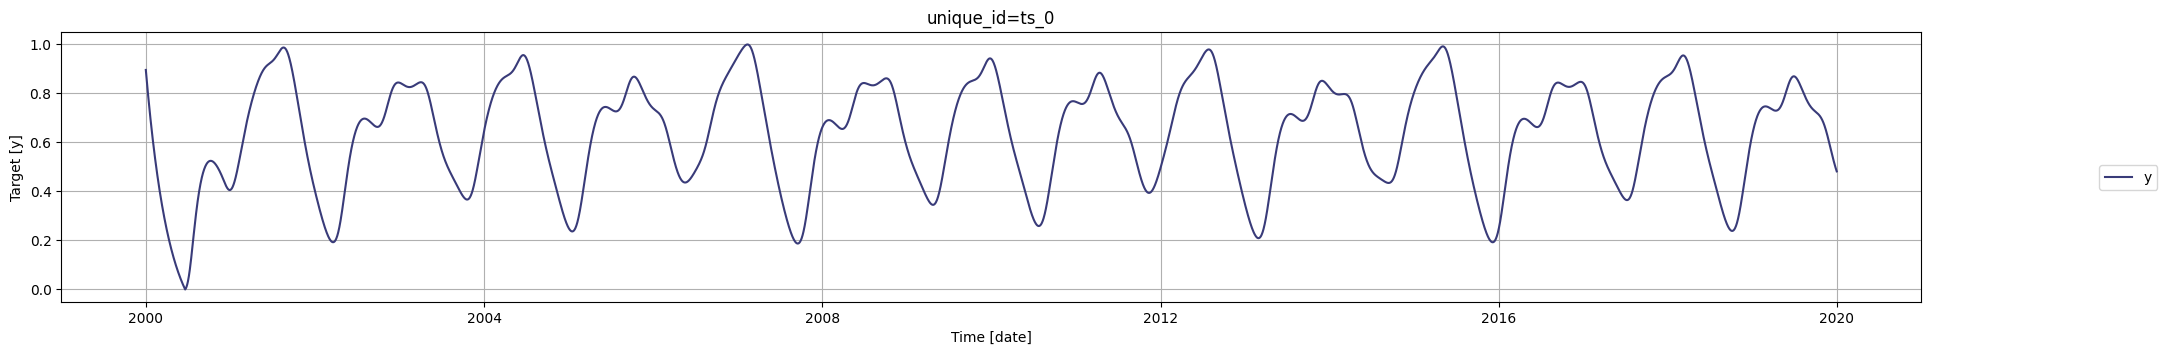

In [ ]:
timegpt.plot(mg_train,time_col = 'date', target_col='y')

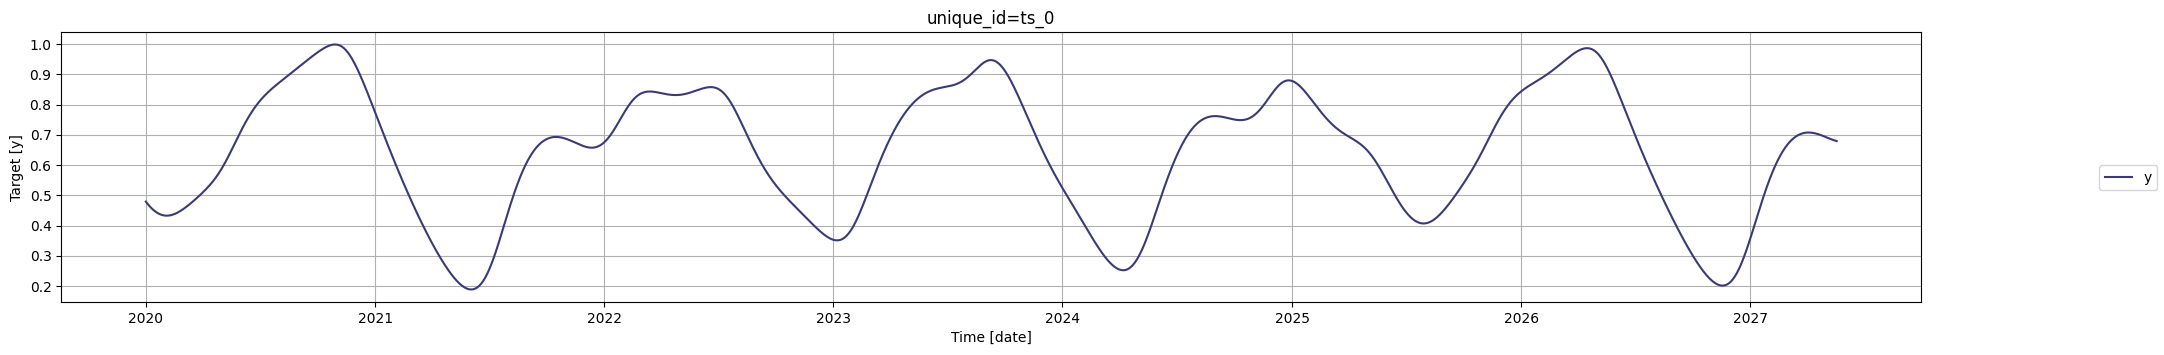

In [ ]:
timegpt.plot(mg_val,time_col = 'date', target_col='y')

#### short forecasting horizon

In [ ]:
timegpt_fcst_df = timegpt.forecast(df=mg_train, h=20, finetune_steps=15, freq='1d', time_col='date', target_col='y')
timegpt_fcst_df.head()

,date,TimeGPT
0,2020-01-01,0.480145
1,2020-01-02,0.478115
2,2020-01-03,0.477579
3,2020-01-04,0.475574
4,2020-01-05,0.474539


<Axes: xlabel='date'>

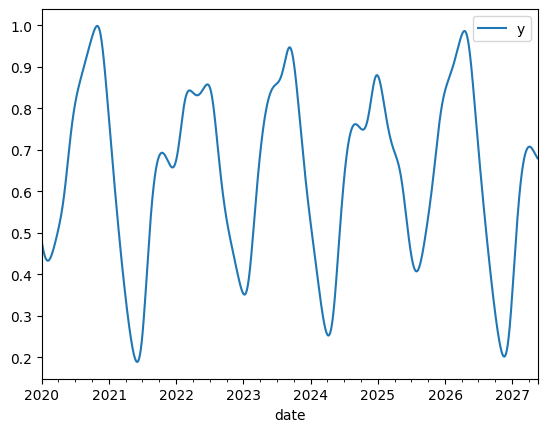

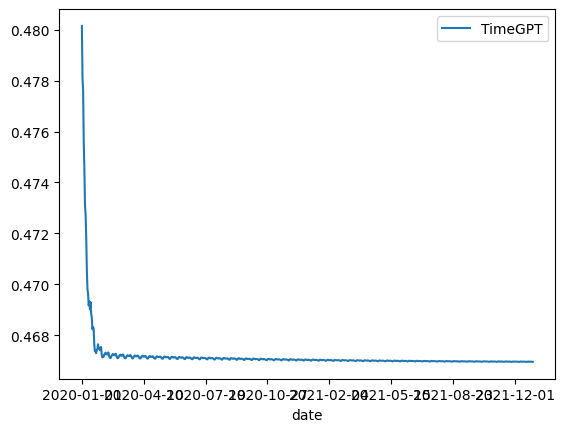

In [ ]:
mg_val.plot(x = 'date', y = 'y')
timegpt_fcst_df.plot(x = 'date', y = 'TimeGPT')

#### longer horizon

In [ ]:
timegpt_fcst_year_ahead = timegpt.forecast(df=mg_train, h=365, freq='1d', finetune_steps=15, time_col='date', target_col='y')
timegpt_fcst_year_ahead

In [ ]:
mg_val.plot(x = 'date', y = 'y')
timegpt_fcst_year_ahead.plot(x = 'date', y = 'TimeGPT')

### electricity dataset

In [ ]:
import numpy as np

def prepare_electricity(electricity_df):
    electricity_df.rename(columns = {'Datetime':'date'}, inplace = True)
    electricity_df['y'] = electricity_df.groupby('date')['PJME_MW'].transform('sum')
    electricity_df['date'] = pd.to_datetime(electricity_df["date"], yearfirst = True)
    electricity_df.drop_duplicates(subset = ['date'], keep = 'first',inplace=True)
    # el.drop(columns = ['date', 'time'], inplace = True)
    electricity_df = electricity_df[electricity_df.date.dt.year>2010]
    'month', 'weekday', 'hour', 'year'
    electricity_df['year'] = electricity_df['date'].dt.year
    electricity_df['hour'] = electricity_df['date'].dt.hour
    electricity_df['month'] = electricity_df['date'].dt.month
    electricity_df['weekday'] = electricity_df['date'].dt.weekday
    electricity_df['unique_id'] = 1
    el_train = electricity_df[electricity_df.date.dt.year<2017]
    el_val = electricity_df[electricity_df.date.dt.year>=2017]

    columns_to_normalize = ['y']
    scaler = MinMaxScaler()
    el_train[columns_to_normalize] = scaler.fit_transform(el_train[columns_to_normalize].values)
    el_val[columns_to_normalize] = scaler.transform(el_val[columns_to_normalize].values)

    el_train.index = np.arange(1, len(el_train) + 1)
    el_val.index = np.arange(1, len(el_val) + 1)
    return el_train, el_val, electricity_df

In [ ]:
el = pd.read_csv('PJME_hourly.csv')
el.head()

In [ ]:
el_train, el_val, el = prepare_electricity(el)

In [ ]:
el_train.tail()

,date,PJME_MW,y,year,hour,month,weekday,unique_id
52595,2016-01-01 20:00:00,32530.0,0.381852,2016,20,1,4,1
52596,2016-01-01 21:00:00,32131.0,0.373381,2016,21,1,4,1
52597,2016-01-01 22:00:00,31318.0,0.356121,2016,22,1,4,1
52598,2016-01-01 23:00:00,29930.0,0.326653,2016,23,1,4,1
52599,2016-01-02 00:00:00,28315.0,0.292366,2016,0,1,5,1


In [ ]:
el_train = el_train.sort_values('date', axis = 0)
el_val = el_val.sort_values('date', axis = 0)

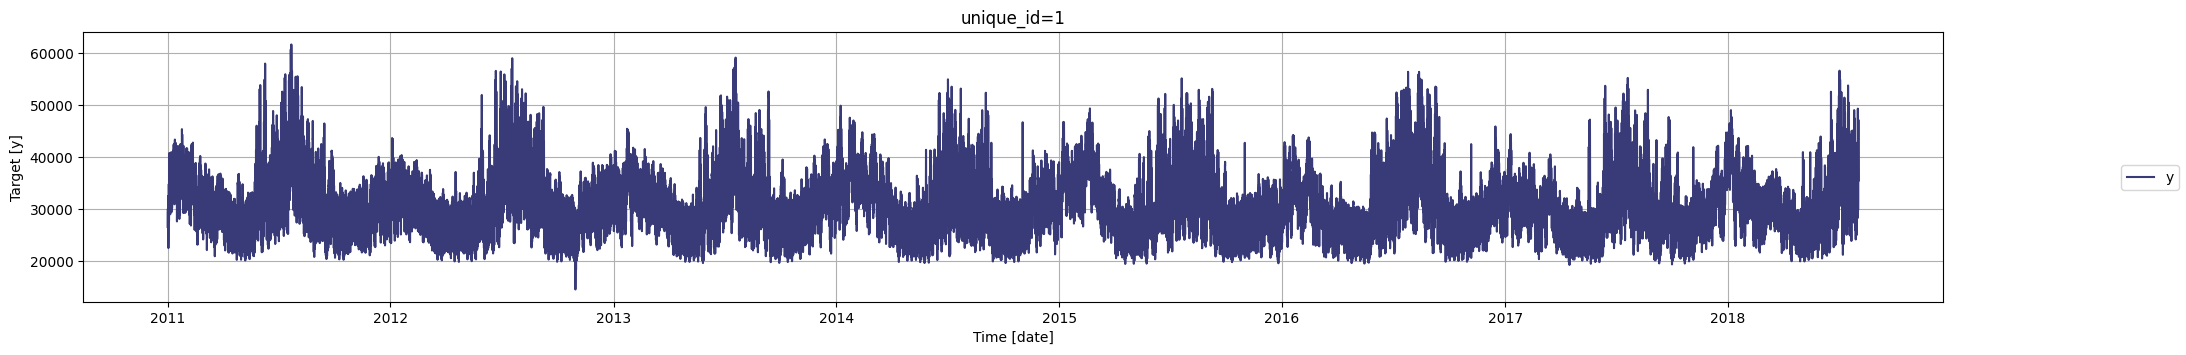

In [ ]:
timegpt.plot(el, time_col='date', target_col='y')

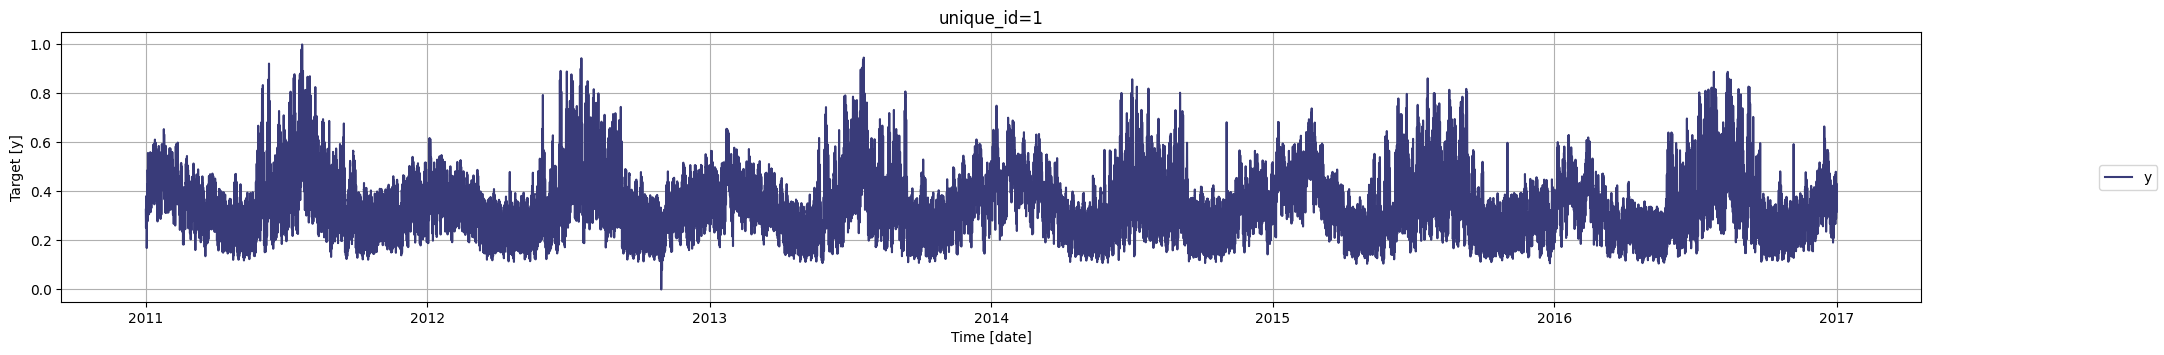

In [ ]:
timegpt.plot(el_train, time_col='date', target_col='y')

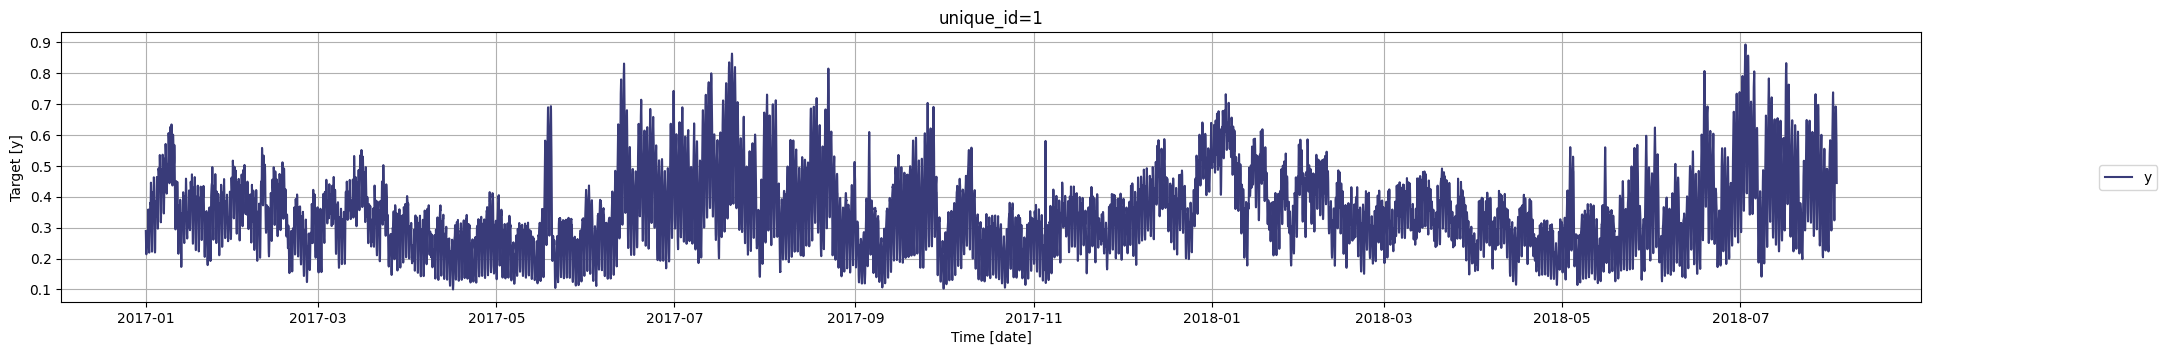

In [ ]:
timegpt.plot(el_val, time_col='date', target_col='y')

In [ ]:
train_values = el_train[['date', 'unique_id','y']]
train_exogenous = el_train[['date', 'unique_id', 'month', 'weekday', 'hour', 'year']]
val_exogenous = el_val[['date', 'unique_id', 'month', 'weekday', 'hour', 'year']]

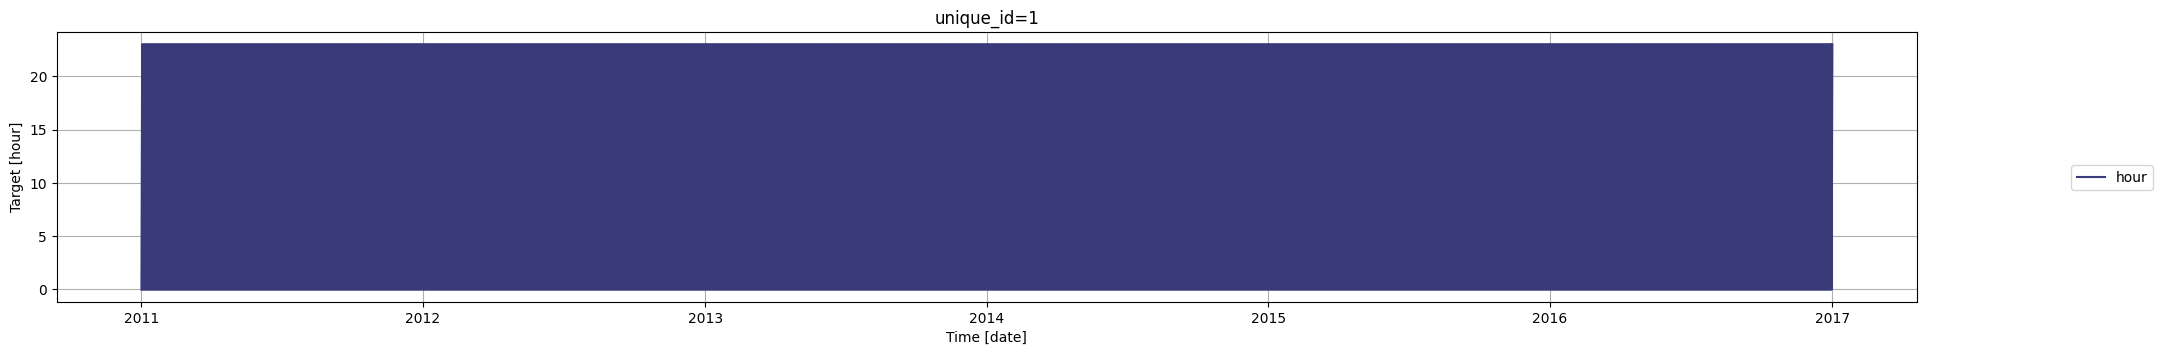

In [ ]:
timegpt.plot(train_exogenous, time_col='date', target_col='hour')

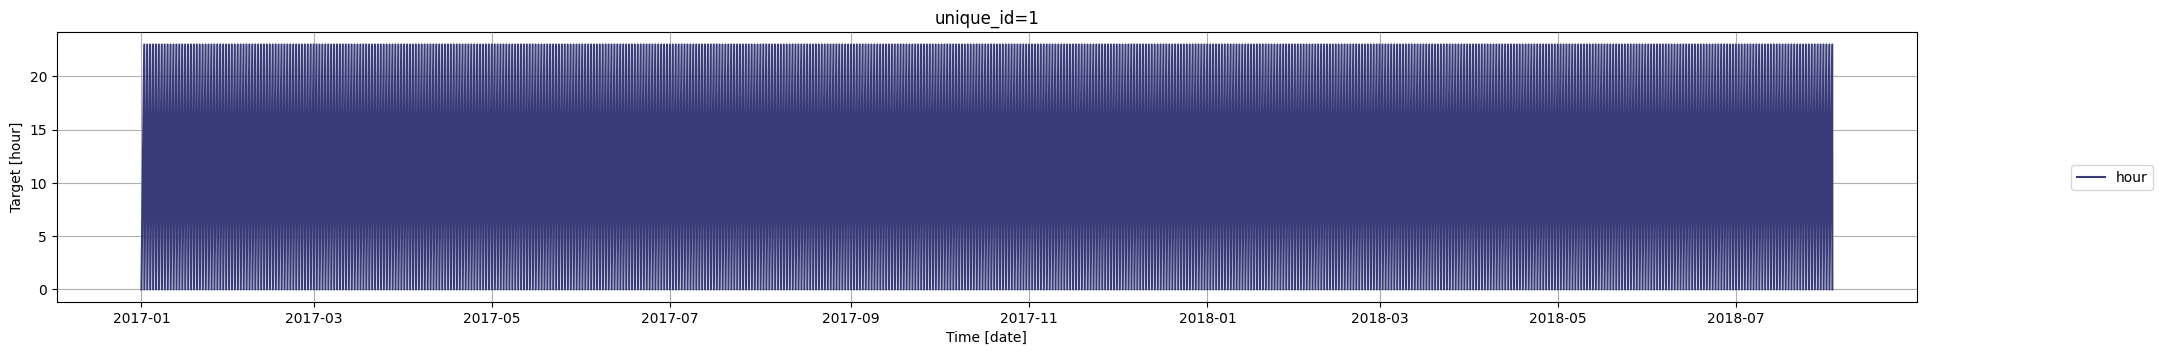

In [ ]:
timegpt.plot(val_exogenous, time_col='date', target_col = 'hour')

In [ ]:
train_exogenous.tail()

,date,unique_id,month,weekday,hour,year
43836,2016-12-31 19:00:00,1,12,5,19,2016
43837,2016-12-31 20:00:00,1,12,5,20,2016
43838,2016-12-31 21:00:00,1,12,5,21,2016
43839,2016-12-31 22:00:00,1,12,5,22,2016
43840,2016-12-31 23:00:00,1,12,5,23,2016


In [ ]:
val_exogenous.values.shape

(13895, 6)

In [ ]:
electricity_short = timegpt.forecast(df=el_train, time_col = 'date', freq = '1h', X_df=val_exogenous[:24], h=24, level=[80, 90])
electricity_short.head()

,unique_id,date,TimeGPT,TimeGPT-lo-90,TimeGPT-lo-80,TimeGPT-hi-80,TimeGPT-hi-90
0,1,2017-01-01 00:00:00,0.289038,0.239093,0.243348,0.334727,0.338982
1,1,2017-01-01 01:00:00,0.261190,0.166608,0.177232,0.345148,0.355773
2,1,2017-01-01 02:00:00,0.247239,0.122710,0.144780,0.349699,0.371769
3,1,2017-01-01 03:00:00,0.240985,0.099779,0.128742,0.353228,0.382191
4,1,2017-01-01 04:00:00,0.242836,0.092368,0.125642,0.360029,0.393303


<Axes: xlabel='date'>

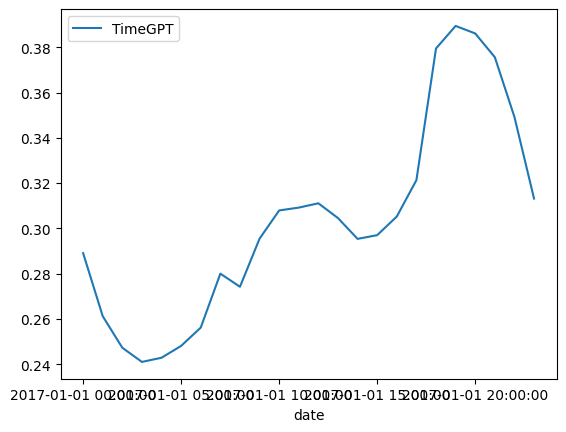

In [ ]:
electricity_short.plot(x = 'date', y = 'TimeGPT')

<Axes: xlabel='date'>

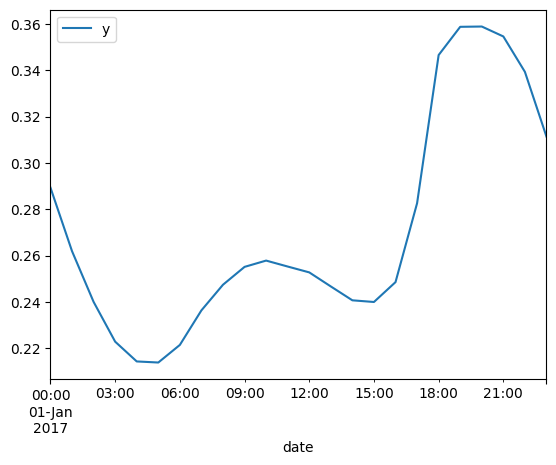

In [ ]:
el_val[:24].plot(x = 'date', y= 'y')

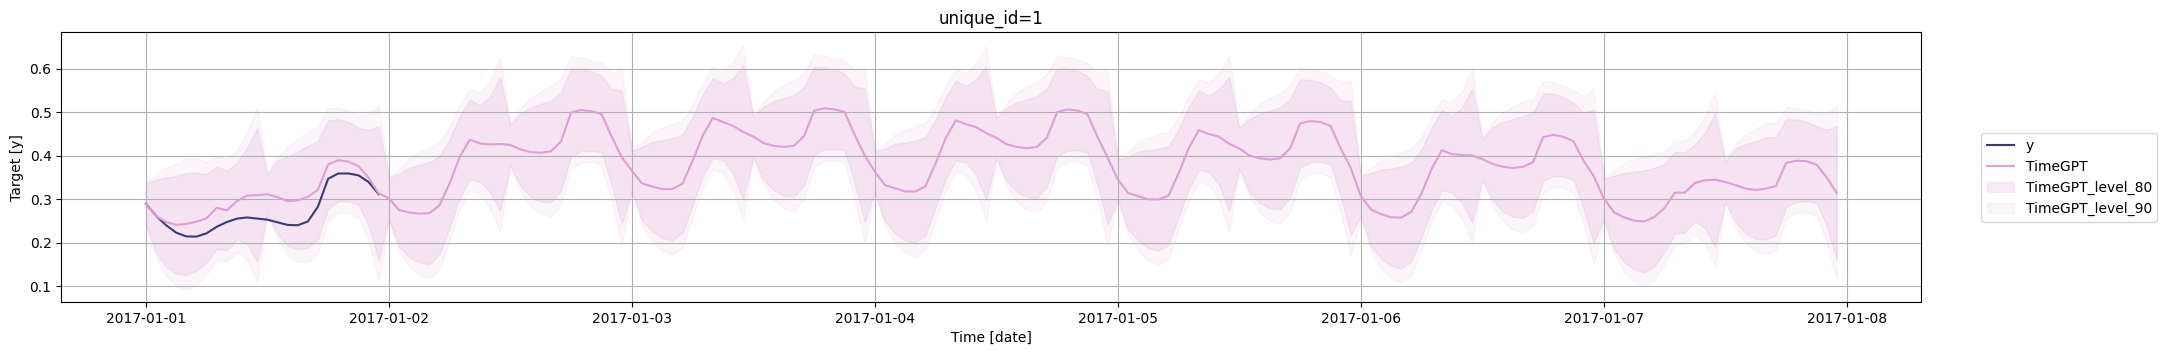

In [ ]:
timegpt.plot(
    el_val[['unique_id', 'date', 'y']][:24],
    electricity_short,
    max_insample_length=365*10,
    level=[80, 90],
    time_col = 'date',
    target_col = 'y',
)


#### longer range prediction

In [ ]:
electricity_long = timegpt.forecast(df=el_train, time_col = 'date', freq = '1h', X_df=val_exogenous[:7*24], h=24*7, level=[80, 90])
electricity_long.head()

,unique_id,date,TimeGPT,TimeGPT-lo-90,TimeGPT-lo-80,TimeGPT-hi-80,TimeGPT-hi-90
0,1,2017-01-01 00:00:00,0.289038,0.239093,0.243348,0.334727,0.338982
1,1,2017-01-01 01:00:00,0.261190,0.166608,0.177232,0.345148,0.355773
2,1,2017-01-01 02:00:00,0.247239,0.122710,0.144780,0.349699,0.371769
3,1,2017-01-01 03:00:00,0.240985,0.099779,0.128742,0.353228,0.382191
4,1,2017-01-01 04:00:00,0.242836,0.092368,0.125642,0.360029,0.393303


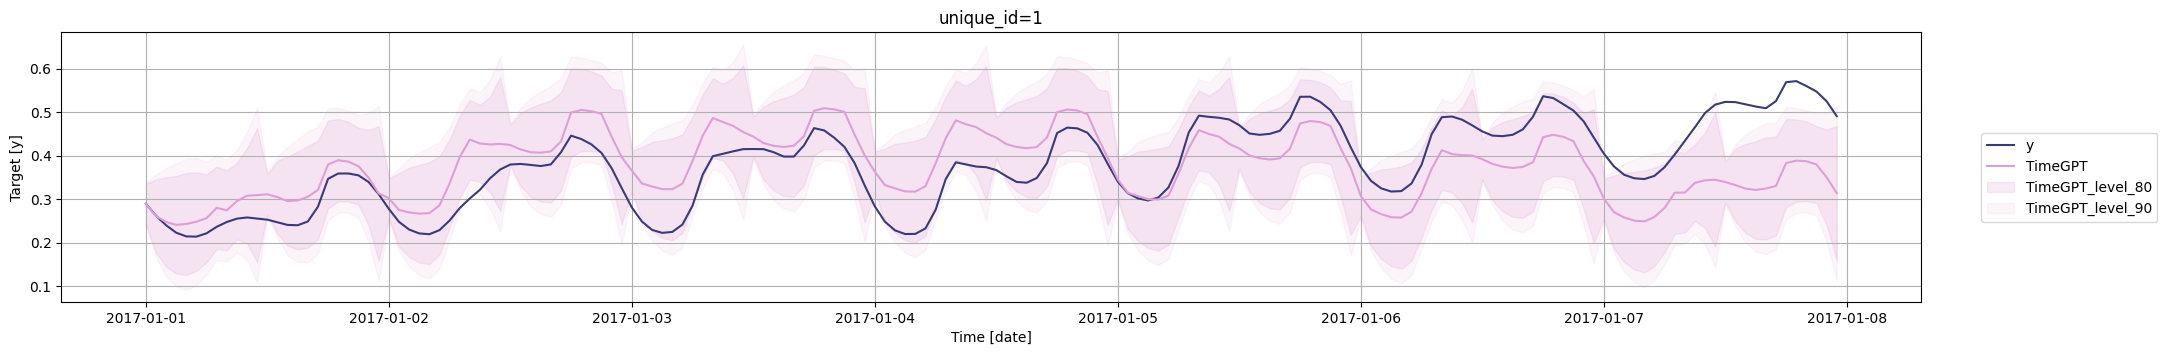

In [ ]:
timegpt.plot(
    el_val[['unique_id', 'date', 'y']][:7*24],
    electricity_long,
    max_insample_length=365*10,
    level=[80, 90],
    time_col = 'date',
    target_col = 'y',
)


<Axes: xlabel='date'>

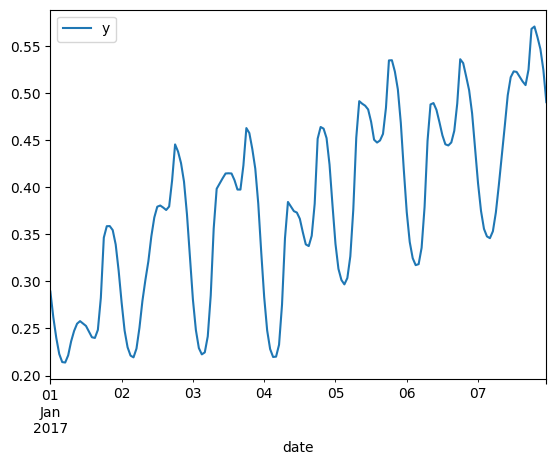

In [ ]:
el_val[:7*24].plot(x = 'date', y= 'y')

<Axes: xlabel='date'>

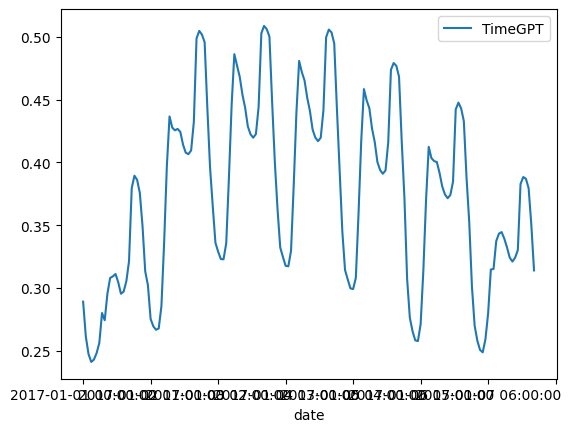

In [ ]:
electricity_long.plot(x = 'date', y = 'TimeGPT')

### Budapest dataset

In [ ]:
!unzip chick.zip

Archive:  chick.zip
replace hungary_chickenpox.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
def prepare_chick(chick):
    chick['date'] = pd.to_datetime(chick["Date"], dayfirst = True)
    chick.drop_duplicates(subset = ['date'],inplace=True)
    chick.drop(columns = ['Date'], inplace = True)

    chick['year'] = chick['date'].dt.year
    chick['month'] = chick['date'].dt.month
    chick['unique_id'] = 1
    chick = chick[chick.date.dt.year>=2008]
    chick_train, chick_val = chick[chick.date.dt.year<=2013], chick[chick.date.dt.year>2013]

    columns_to_normalize = ['BUDAPEST']
    scaler = MinMaxScaler()
    chick_train[columns_to_normalize] = scaler.fit_transform(chick_train[columns_to_normalize].values)
    chick_val[columns_to_normalize] = scaler.transform(chick_val[columns_to_normalize].values)

    chick_train.index = np.arange(1, len(chick_train) + 1)
    chick_val.index = np.arange(1, len(chick_val) + 1)
    return chick_train, chick_val, chick

In [ ]:
chick_df = pd.read_csv('hungary_chickenpox.csv')

In [ ]:
chick_train, chick_val, chick = prepare_chick(chick_df)

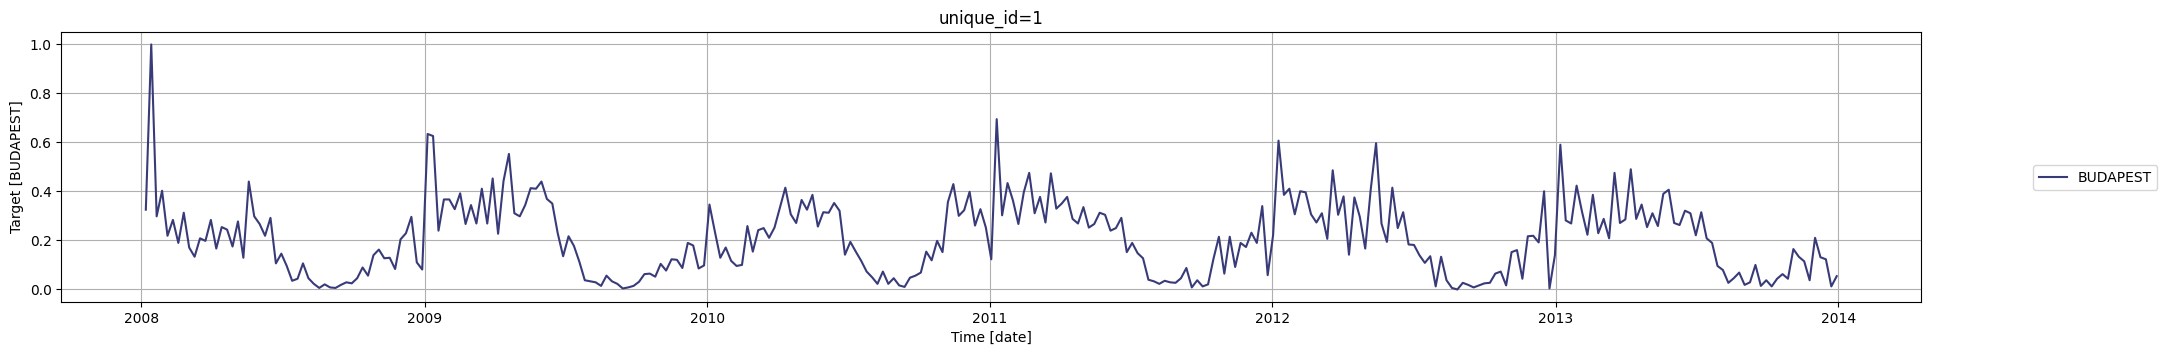

In [ ]:
timegpt.plot(chick_train, time_col='date', target_col='BUDAPEST')

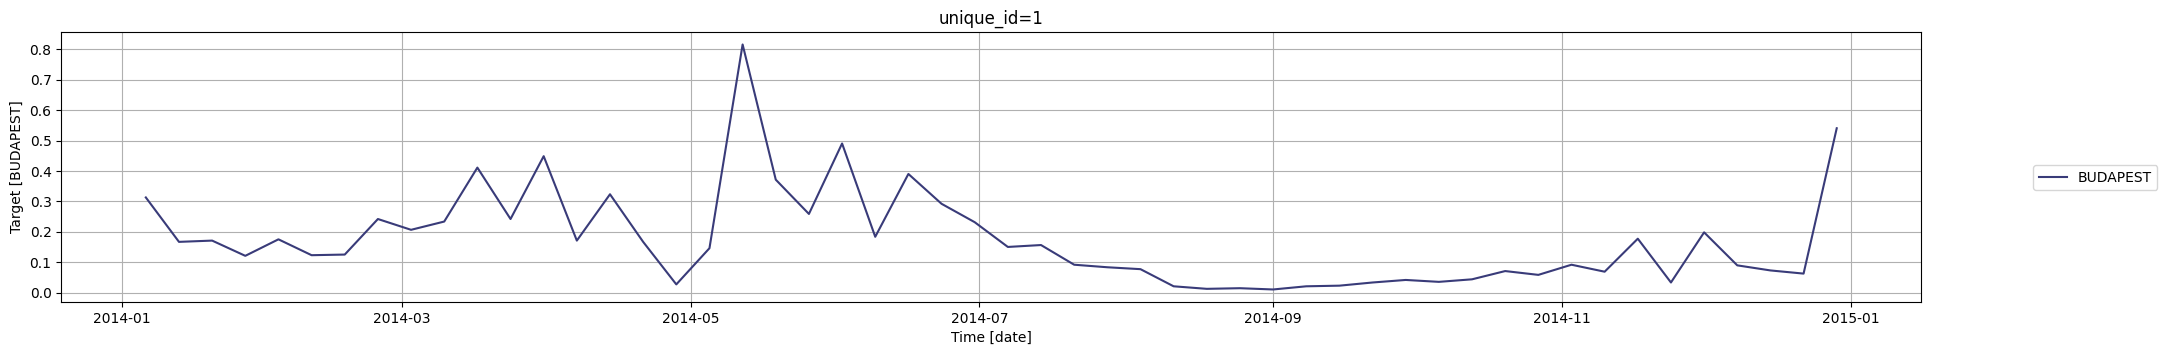

In [ ]:
timegpt.plot(chick_val, time_col='date', target_col='BUDAPEST')

#### Short range prediction

In [ ]:
train_values = chick_train[['date', 'unique_id','BUDAPEST']]
train_exogenous = chick_train[['date', 'unique_id', 'month', 'year']]
val_exogenous = chick_val[['date', 'unique_id', 'month', 'year']]

In [ ]:
chick_short = timegpt.forecast(df=chick_train, finetune_steps=15, target_col = 'BUDAPEST', time_col = 'date', freq = '7d', X_df=val_exogenous[:1], h=1, level=[80, 90])
chick_short.head()

,unique_id,date,TimeGPT,TimeGPT-lo-90,TimeGPT-lo-80,TimeGPT-hi-80,TimeGPT-hi-90
0,1,2014-01-06,0.333521,0.213902,0.247552,0.419489,0.453139


In [ ]:
chick_val[:1]['BUDAPEST']

1    0.313152
Name: BUDAPEST, dtype: float64

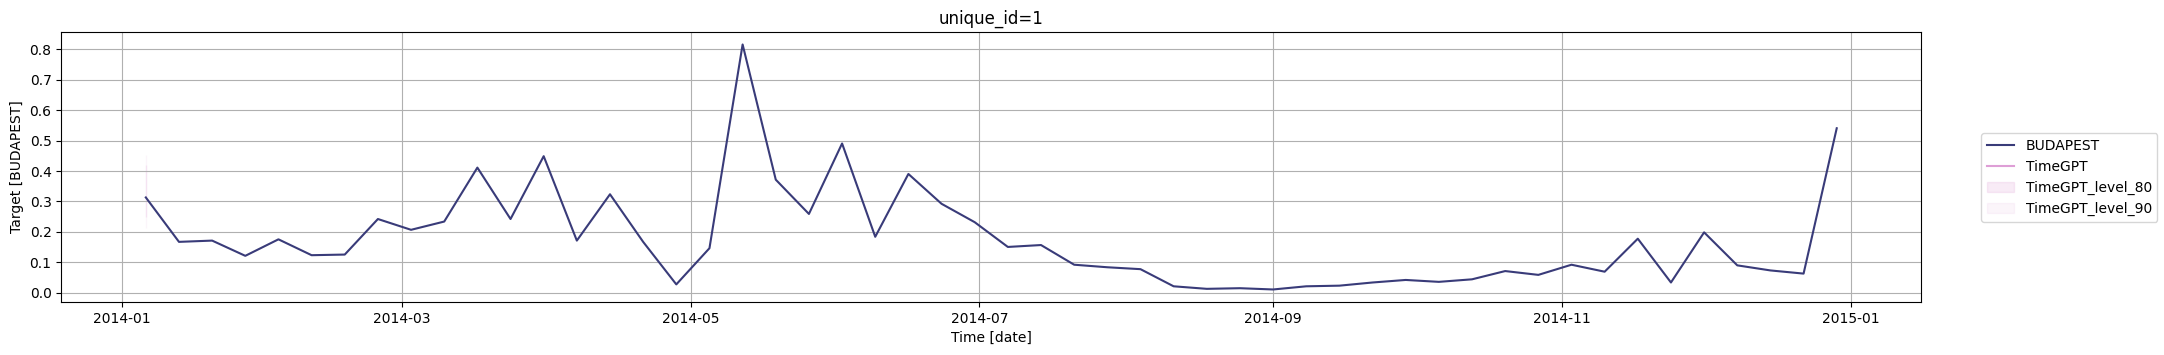

In [ ]:
timegpt.plot(
    chick_val[['unique_id', 'date', 'BUDAPEST']],
    chick_short,
    max_insample_length=365,
    level=[80, 90],
    time_col = 'date',
    target_col = 'BUDAPEST',
)


#### longer range prediction

In [ ]:
chick_long = timegpt.forecast(df=chick_train,finetune_steps=15, target_col = 'BUDAPEST', time_col = 'date', freq = '7d', X_df=val_exogenous[:7], h=7, level=[80, 90])
chick_long.head()

,unique_id,date,TimeGPT,TimeGPT-lo-90,TimeGPT-lo-80,TimeGPT-hi-80,TimeGPT-hi-90
0,1,2014-01-06,0.333521,0.213902,0.247552,0.419489,0.453139
1,1,2014-01-13,0.334178,0.196531,0.227248,0.441109,0.471826
2,1,2014-01-20,0.344182,0.148309,0.185681,0.502684,0.540056
3,1,2014-01-27,0.339289,0.112529,0.156122,0.522456,0.566049
4,1,2014-02-03,0.267496,-0.023668,0.028694,0.506299,0.558661


In [ ]:
chick_val[:7]['BUDAPEST']

1    0.313152
2    0.167015
3    0.171190
4    0.121086
5    0.175365
6    0.123173
7    0.125261
Name: BUDAPEST, dtype: float64

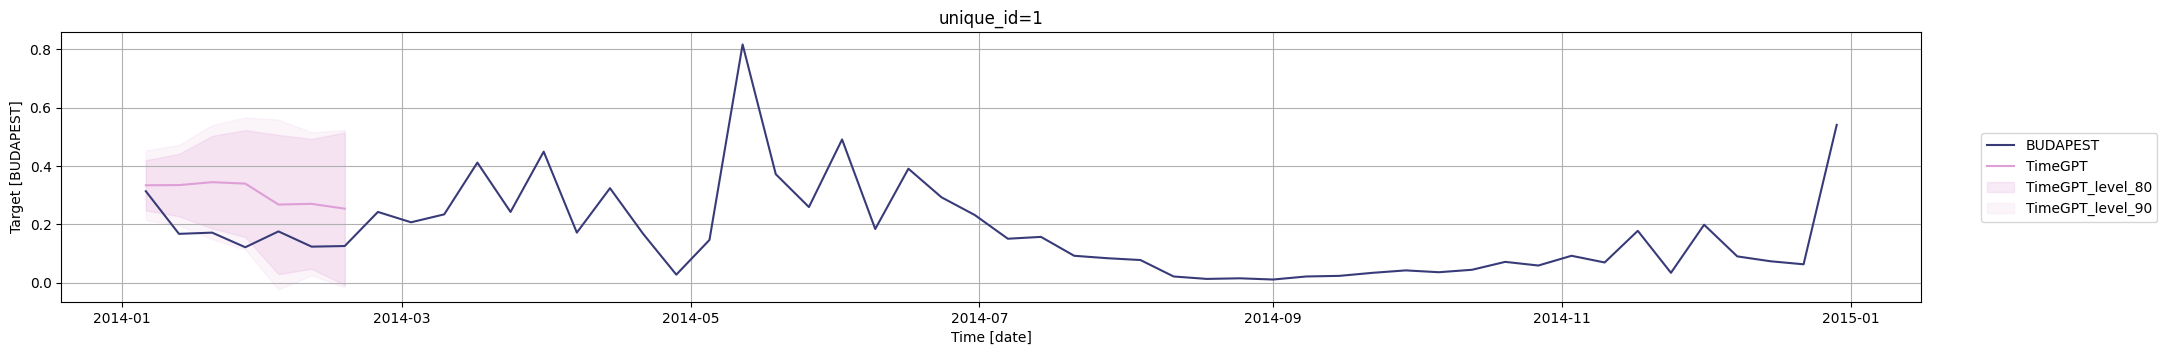

In [ ]:
timegpt.plot(
    chick_val[['unique_id', 'date', 'BUDAPEST']],
    chick_long,
    max_insample_length=365,
    level=[80, 90],
    time_col = 'date',
    target_col = 'BUDAPEST',
)
